In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, roc_curve, auc

from itertools import cycle

import tensorflow as tf
from tensorflow.keras import layers, Model, metrics

SEATTLE dataset

In [2]:
data = pd.read_csv('./seattle-weather.csv')
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


Visualization

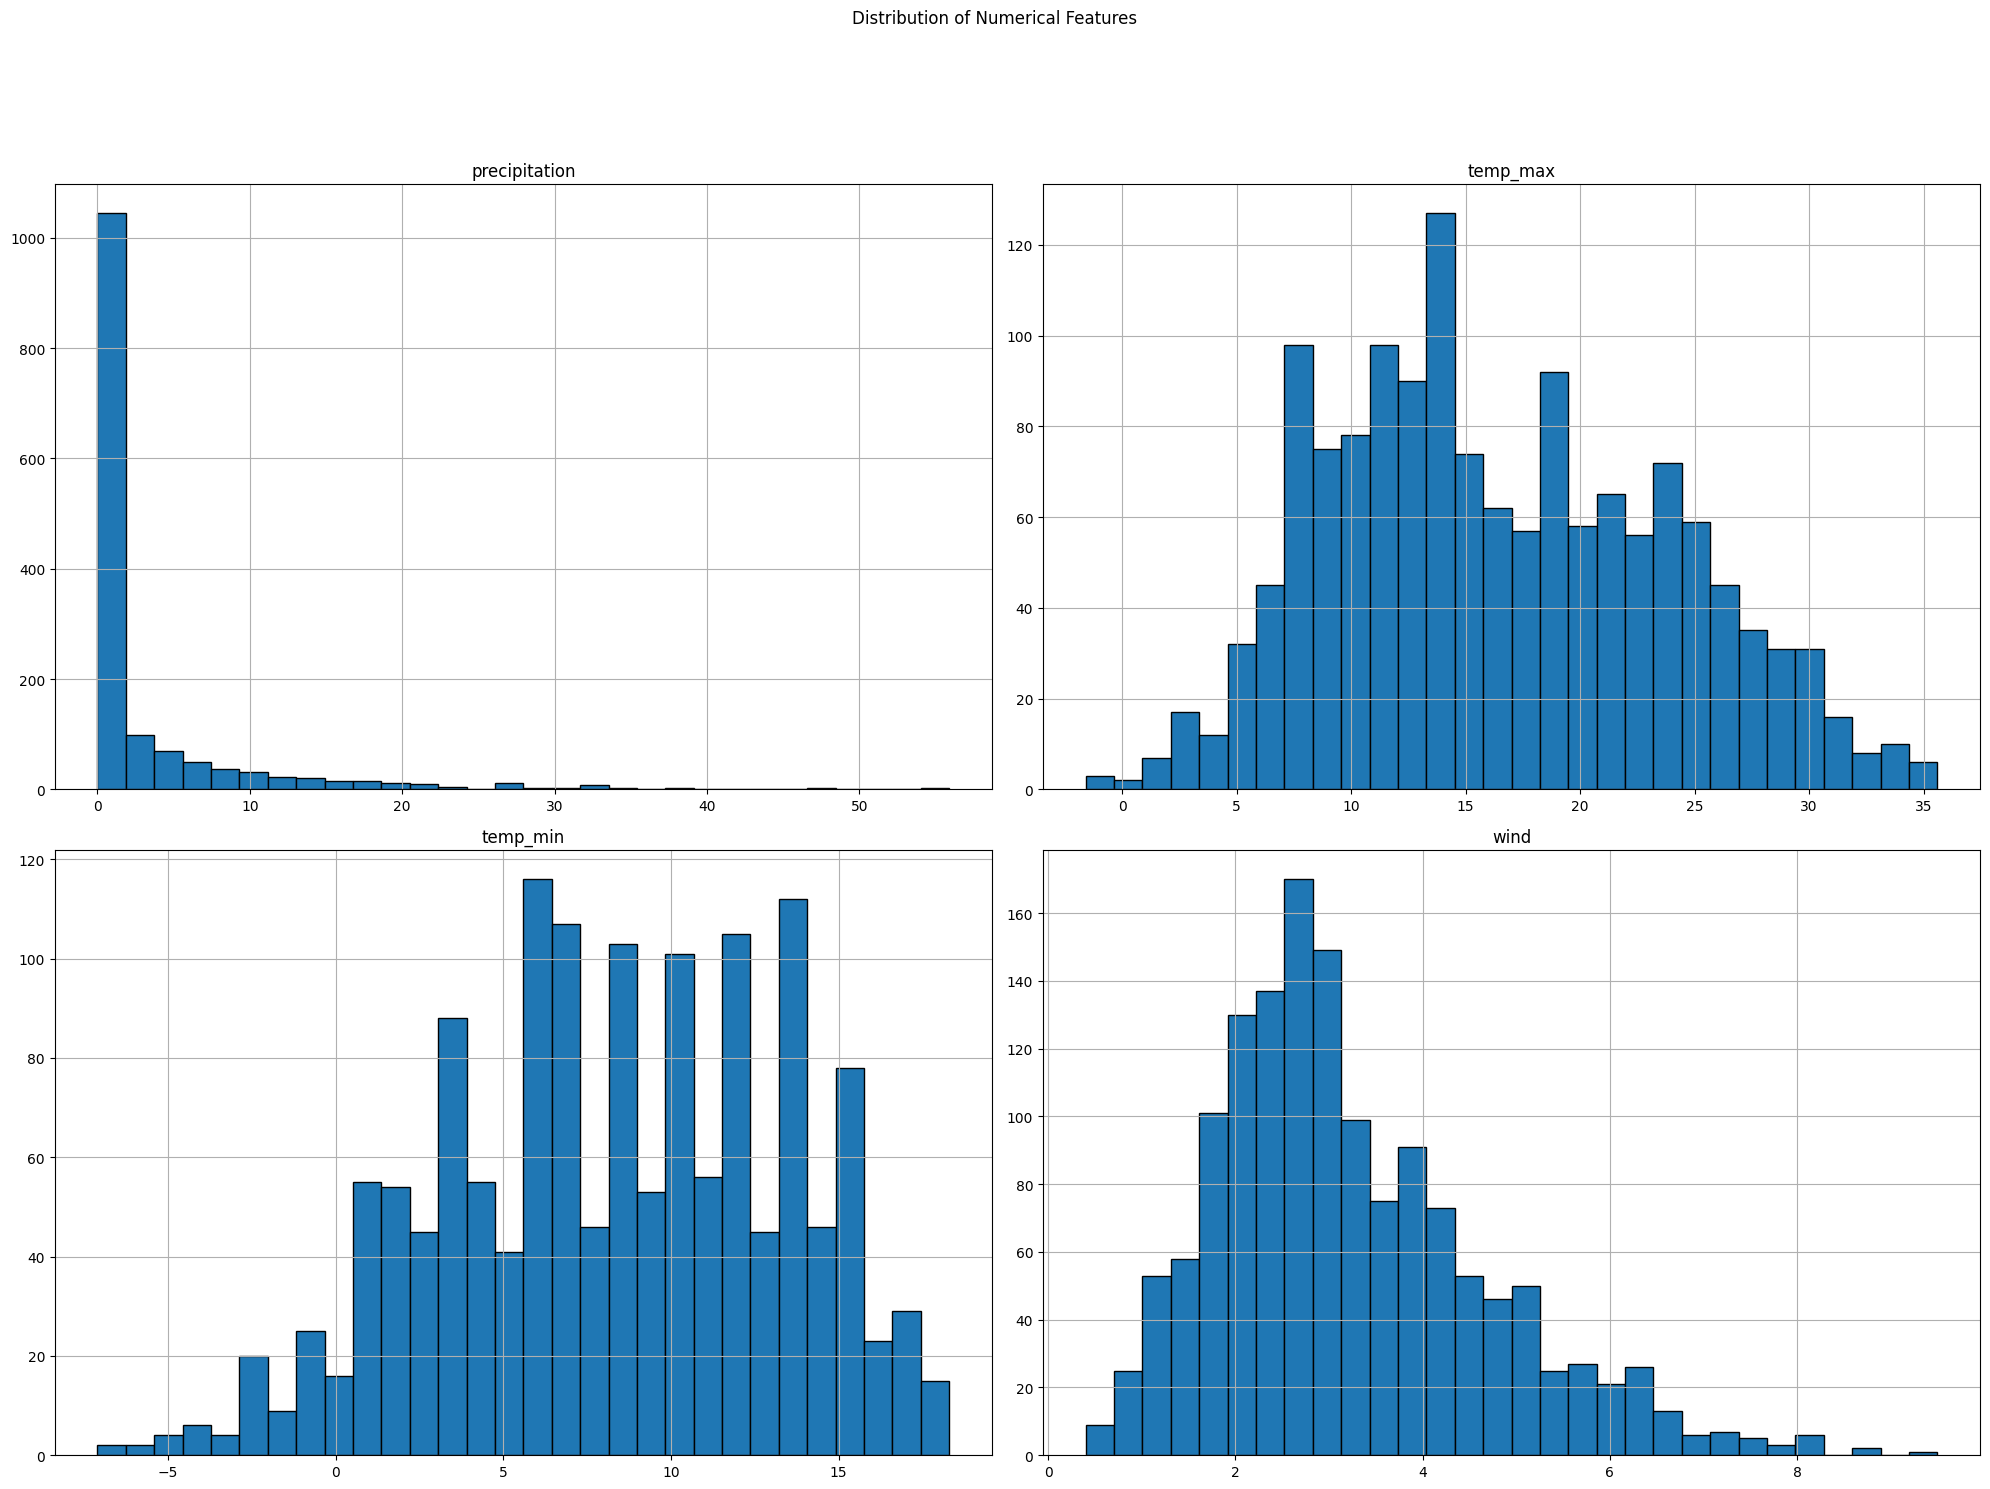

In [3]:
# Select numerical columns
numerical_cols = data.select_dtypes(include=np.number).columns

# Plot histograms for numerical features
data[numerical_cols].hist(figsize=(20, 15), bins=30, edgecolor='black')
plt.suptitle('Distribution of Numerical Features', y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

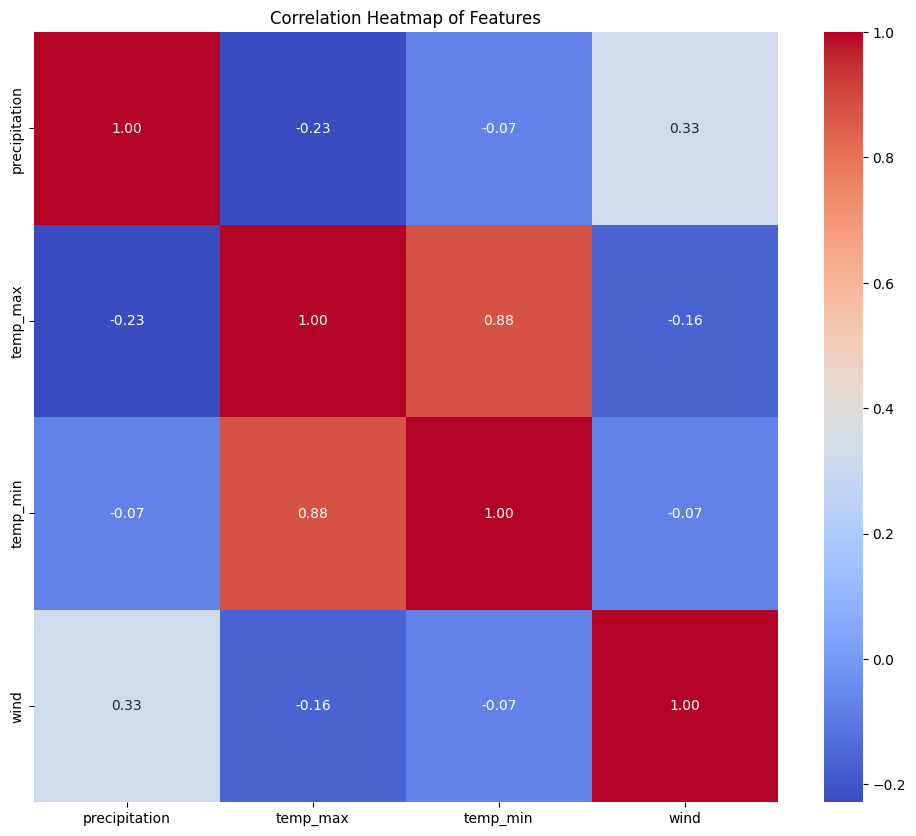

In [4]:
# Calculate the correlation matrix
corr_matrix = data.drop(['weather', 'date'], axis=1).corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features')
plt.show()

Data split

In [5]:
# Separate features (X) and target (y)
X = data.drop(['weather', 'date'], axis=1) # Drop both 'weather' and 'date' from features
y = data['weather']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Robust scaler for outlier

In [6]:
feature_scaler = RobustScaler()

numerical_cols = X_train.select_dtypes(include=np.number).columns

X_train[numerical_cols] = feature_scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = feature_scaler.transform(X_test[numerical_cols])

y_train_encoded = pd.get_dummies(y_train)
y_test_encoded = pd.get_dummies(y_test)

X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.values.reshape((X_test.shape[0],  X_test.shape[1],  1))

print("X_train final shape:", X_train.shape)

X_train final shape: (1168, 4, 1)


BUILD MODELS

TRABSFORMERS

In [7]:
# ---- Positional Encoding ----
class PositionalEncoding(layers.Layer):
    def __init__(self, maxlen, d_model):
        super().__init__()
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=d_model)

    def call(self, x):
        positions = tf.range(start=0, limit=tf.shape(x)[1], delta=1)
        encoded_positions = self.pos_emb(positions)
        return x + encoded_positions


# ---- Transformer Block ----
class TransformerBlock(layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(d_model),
        ])
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training = None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


# ---- Final Transformer Model ----
def build_transformer(input_shape, d_model=64, num_heads=4, ff_dim=128, num_layers=2):
    inputs = layers.Input(shape=input_shape)

    # Project inputs to d_model dimensions
    x = layers.Dense(d_model)(inputs)

    # Positional encoding
    x = PositionalEncoding(input_shape[0], d_model)(x)

    # Stacked Transformer blocks
    for _ in range(num_layers):
        x = TransformerBlock(d_model, num_heads, ff_dim)(x)

    # Output (regression or classification)
    x = layers.GlobalAveragePooling1D()(x)
    n_classes = y_train_encoded.shape[1]
    outputs = layers.Dense(n_classes, activation='softmax')(x)

    return Model(inputs, outputs)


CONFORMER

In [8]:
# ---- Conformer Block ----
class ConformerBlock(layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim, conv_expansion=2, rate=0.1):
        super().__init__()

        # Feed Forward Module 1
        self.ffn1 = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(d_model),
        ])

        # MH Self-Attention
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.norm_att = layers.LayerNormalization()

        # Convolution Module
        self.norm_conv = layers.LayerNormalization()
        self.pointwise_conv1 = layers.Conv1D(conv_expansion * d_model, kernel_size=1, activation='relu')
        self.depthwise_conv = layers.Conv1D(conv_expansion * d_model, kernel_size=3, padding='same', groups=conv_expansion * d_model)
        self.pointwise_conv2 = layers.Conv1D(d_model, kernel_size=1)

        # Feed Forward Module 2
        self.ffn2 = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(d_model),
        ])

        self.norm_final = layers.LayerNormalization()
        self.dropout = layers.Dropout(rate)

    def call(self, x, training=False):

        # FFN 1
        residual = x
        x = self.ffn1(x)
        x = self.dropout(x, training=training)
        x = residual + 0.5 * x

        # MHSA
        attn = self.att(x, x)
        attn = self.dropout(attn, training=training)
        x = self.norm_att(x + attn)

        # Convolution Module
        conv = self.norm_conv(x)
        conv = self.pointwise_conv1(conv)
        conv = self.depthwise_conv(conv)
        conv = layers.Activation("swish")(conv)
        conv = self.pointwise_conv2(conv)
        x = x + conv

        # FFN 2
        ffn_out = self.ffn2(x)
        ffn_out = self.dropout(ffn_out, training=training)
        x = x + 0.5 * ffn_out

        return self.norm_final(x)


# ---- Final Conformer Model ----
def build_conformer(input_shape, d_model=64, num_heads=4, ff_dim=128, num_layers=2):
    inputs = layers.Input(shape=input_shape)

    # Project raw features to d_model dimension
    x = layers.Dense(d_model)(inputs)

    # Positional encoding
    x = PositionalEncoding(input_shape[0], d_model)(x)

    # Stacked Conformer blocks
    for _ in range(num_layers):
        x = ConformerBlock(d_model, num_heads, ff_dim)(x)

    # Output head
    x = layers.GlobalAveragePooling1D()(x)
    n_classes = y_train_encoded.shape[1]
    outputs = layers.Dense(n_classes, activation='softmax')(x)


    return Model(inputs, outputs)


In [9]:
transformer_model = build_transformer(input_shape=(X_train.shape[1], X_train.shape[2]))
transformer_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)
conformer_model = build_conformer(input_shape=(X_train.shape[1], X_train.shape[2]))
conformer_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)
# model.summary()

Training

In [10]:
# Train Transformer model
history_transformer = transformer_model.fit(
    X_train, 
    y_train_encoded,
    validation_data=(X_test, y_test_encoded),
    epochs=100,
    batch_size=32
)

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7149 - loss: 0.8836 - precision: 0.7530 - recall: 0.6473 - val_accuracy: 0.8055 - val_loss: 0.6011 - val_precision: 0.8188 - val_recall: 0.8020
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8296 - loss: 0.5756 - precision: 0.8482 - recall: 0.8134 - val_accuracy: 0.8191 - val_loss: 0.5637 - val_precision: 0.8185 - val_recall: 0.8157
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8382 - loss: 0.5428 - precision: 0.8427 - recall: 0.8305 - val_accuracy: 0.8259 - val_loss: 0.5483 - val_precision: 0.8247 - val_recall: 0.8191
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8442 - loss: 0.5192 - precision: 0.8448 - recall: 0.8390 - val_accuracy: 0.8259 - val_loss: 0.5710 - val_precision: 0.8259 - val_recall: 0.8259
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8365 - loss: 0.5421 - precision: 0.8467 - recall: 0.8228 - val_accuracy: 0.8157 - val_loss: 0.

In [11]:
# Train Conformer model
history_conformer = conformer_model.fit(
    X_train,
    y_train_encoded,
    validation_data=(X_test, y_test_encoded),
    epochs=100,
    batch_size=32
)

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.7158 - loss: 0.8138 - precision: 0.7595 - recall: 0.6704 - val_accuracy: 0.8225 - val_loss: 0.6047 - val_precision: 0.8322 - val_recall: 0.8123
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8485 - loss: 0.5354 - precision: 0.8500 - recall: 0.8348 - val_accuracy: 0.8294 - val_loss: 0.5495 - val_precision: 0.8294 - val_recall: 0.8294
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8485 - loss: 0.5196 - precision: 0.8514 - recall: 0.8339 - val_accuracy: 0.8328 - val_loss: 0.5489 - val_precision: 0.8322 - val_recall: 0.8294
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8519 - loss: 0.5323 - precision: 0.8520 - recall: 0.8476 - val_accuracy: 0.8294 - val_loss: 0.4922 - val_precision: 0.8294 - val_recall: 0.8294
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8519 - loss: 0.4992 - precision: 0.8543 - recall: 0.8485 - val_accuracy: 0.8328 - val_loss: 0.

Evaluation

In [12]:
loss_trans, acc_trans, prec_trans, rec_trans = transformer_model.evaluate(X_test, y_test_encoded)
print(f"Transformer — Test Loss: {loss_trans:.4f}")
print(f"Transformer — Test Accuracy: {acc_trans * 100:.2f}%")
print(f"Transformer — Test Precision: {prec_trans * 100:.2f}%")
print(f"Transformer — Test Recall: {rec_trans * 100:.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8225 - loss: 0.5206 - precision: 0.8556 - recall: 0.8089 
Transformer — Test Loss: 0.5206
Transformer — Test Accuracy: 82.25%
Transformer — Test Precision: 85.56%
Transformer — Test Recall: 80.89%


In [13]:
loss_conf, acc_conf, prec_conf, rec_conf = conformer_model.evaluate(X_test, y_test_encoded)
print(f"Conformer — Test Loss: {loss_conf:.4f}")
print(f"Conformer — Test Accuracy: {acc_conf * 100:.2f}%")
print(f"Conformer — Test Precision: {prec_conf * 100:.2f}%")
print(f"Conformer — Test Recall: {rec_conf * 100:.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8362 - loss: 0.5118 - precision: 0.8432 - recall: 0.8259
Conformer — Test Loss: 0.5118
Conformer — Test Accuracy: 83.62%
Conformer — Test Precision: 84.32%
Conformer — Test Recall: 82.59%


In [14]:
results = pd.DataFrame({
    "Model": ["Transformer", "Conformer"],
    "Loss": [loss_trans, loss_conf],
    "Accuracy": [acc_trans, acc_conf],
    "Precision": [prec_trans, prec_conf],
    "Recall": [rec_trans, rec_conf]
})

print(results)

         Model      Loss  Accuracy  Precision    Recall
0  Transformer  0.520578  0.822526   0.855596  0.808874
1    Conformer  0.511818  0.836177   0.843206  0.825939


Model plotting

In [15]:
print("Transformer keys:", history_transformer.history.keys())
print("Conformer keys:", history_conformer.history.keys())

Transformer keys: dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])
Conformer keys: dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])


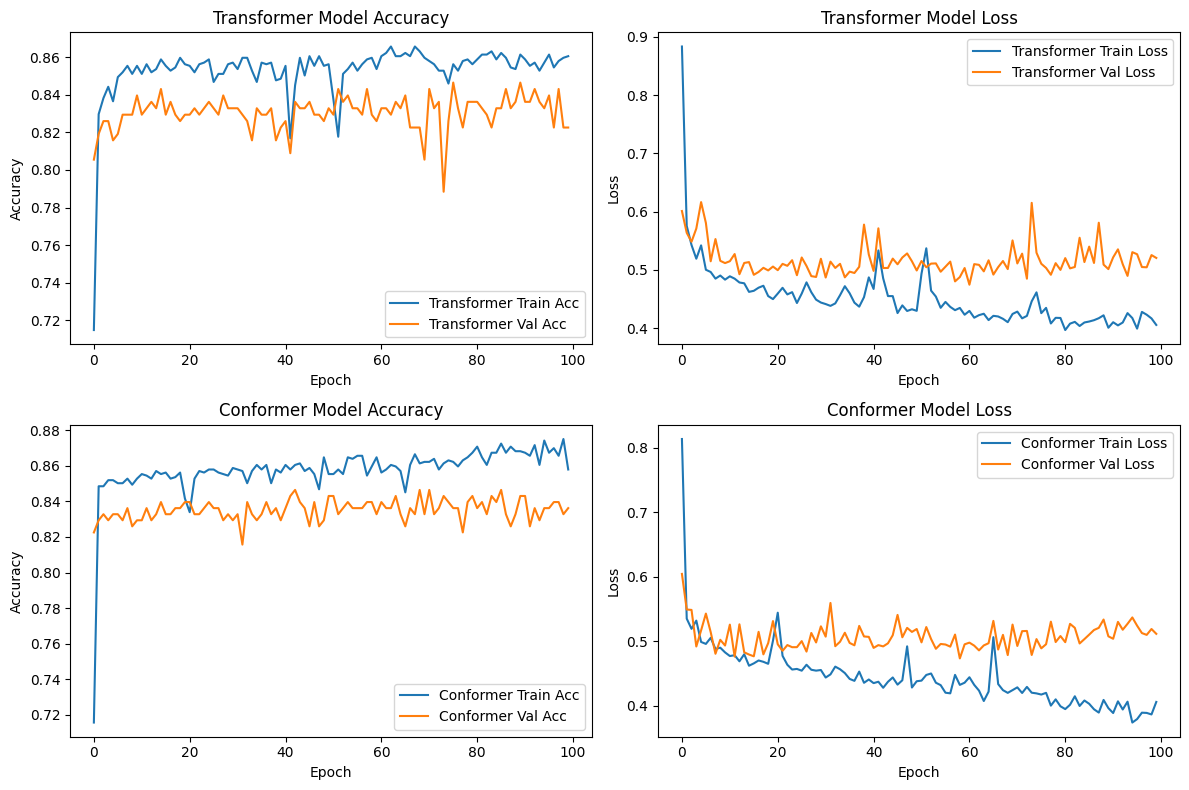

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# -----------------------------
# 1. Transformer Accuracy
# -----------------------------
plt.subplot(2, 2, 1)
plt.plot(history_transformer.history['accuracy'], label='Transformer Train Acc')
plt.plot(history_transformer.history['val_accuracy'], label='Transformer Val Acc')
plt.title('Transformer Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# -----------------------------
# 2. Transformer Loss
# -----------------------------
plt.subplot(2, 2, 2)
plt.plot(history_transformer.history['loss'], label='Transformer Train Loss')
plt.plot(history_transformer.history['val_loss'], label='Transformer Val Loss')
plt.title('Transformer Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# -----------------------------
# 3. Conformer Accuracy
# -----------------------------
plt.subplot(2, 2, 3)
plt.plot(history_conformer.history['accuracy'], label='Conformer Train Acc')
plt.plot(history_conformer.history['val_accuracy'], label='Conformer Val Acc')
plt.title('Conformer Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# -----------------------------
# 4. Conformer Loss
# -----------------------------
plt.subplot(2, 2, 4)
plt.plot(history_conformer.history['loss'], label='Conformer Train Loss')
plt.plot(history_conformer.history['val_loss'], label='Conformer Val Loss')
plt.title('Conformer Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Predictions

In [17]:
def evaluate_model(model, X_test, y_test_encoded):
    # Predict probabilities
    y_score = model.predict(X_test)

    # True labels (strings)
    y_true_labels = y_test_encoded.idxmax(axis=1)

    # Predicted label indices
    y_pred_indices = y_score.argmax(axis=1)

    # Map indices → class names
    y_pred_labels = y_test_encoded.columns[y_pred_indices]

    # Confusion matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels)

    return cm, y_true_labels, y_pred_labels


In [18]:
cm_transformer, y_true_transformer, y_pred_transformer = evaluate_model(
    transformer_model, X_test, y_test_encoded
)
cm_conformer, y_true_conformer, y_pred_conformer = evaluate_model(
    conformer_model, X_test, y_test_encoded
)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


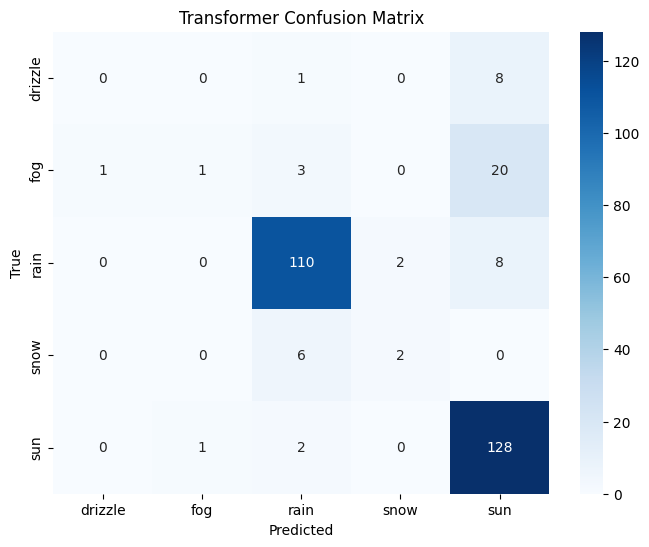

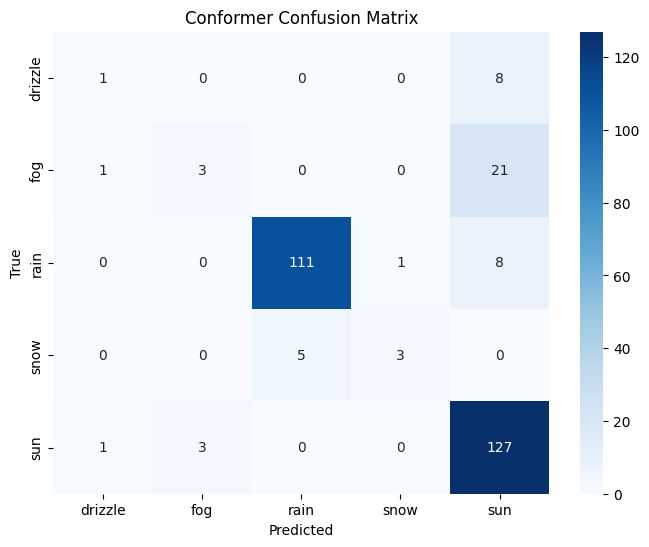

In [19]:
def plot_cm(cm, labels, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

plot_cm(cm_transformer, y_test_encoded.columns, "Transformer Confusion Matrix")
plot_cm(cm_conformer, y_test_encoded.columns, "Conformer Confusion Matrix")


T TEST

In [20]:
from scipy.stats import ttest_rel

# Convert true and predicted labels to numpy arrays
y_true = np.array(y_true_transformer)   # Same true labels for both models
y_pred_t = np.array(y_pred_transformer)  # Predicted by Transformer
y_pred_c = np.array(y_pred_conformer)   # Predicted by Conformer

# Convert labels to binary correctness (1 = correct, 0 = incorrect)
acc_t = (y_pred_t == y_true).astype(int)
acc_c = (y_pred_c == y_true).astype(int)

# Paired t-test
t_stat, p_value = ttest_rel(acc_t, acc_c)

print("Paired T-Test for Accuracy:")
print("t-statistic:", t_stat)
print("p-value:", p_value)

# Optional: effect size
cohen_d = (acc_c.mean() - acc_t.mean()) / np.sqrt(((acc_t.std() ** 2 + acc_c.std() ** 2) / 2))
print("Cohen's d:", cohen_d)


Paired T-Test for Accuracy:
t-statistic: -1.26621263642069
p-value: 0.20644617003180746
Cohen's d: 0.03629471186009164
